# Hybrid Dual Model: Hybrid Physics-Neural Network Model Led by a GMM

This notebook uses a Gaussian Mixture Model to segment out the pre-shot data, then use that initial trajectory in a physics-based model, assisted by predicting variables with a neural network (XGBoost???)

## 1. Import Required Libraries

In [1]:
import json
from pathlib import Path
from typing import List, Optional, Tuple
import ast
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gmm_training as gmmt
import seaborn as sns

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Ensure updated modules are picked up without restarting the kernel
%load_ext autoreload
%autoreload 2
import importlib
import physics.constants as const
importlib.reload(const)
from physics.constants import R_WORLD_TO_RIM, R_HOOP_WORLD, T_WORLD_TO_RIM
print('physics.constants reloaded')

physics.constants reloaded


## 2 Load and Preprocess the Data (Sahar's GMM Code)

In [3]:
# Load training data
csv_path = "train.csv"
cols_to_remove = ["id", "shot_id", "angle", "depth", "left_right"]
shots, valid_row_idx, signal_cols = gmmt.load_shots_from_csv(csv_path, cols_to_remove)
X = gmmt.stack_timepoints(shots)

Kept 345 / 345 shots after parsing + NaN handling.
n_signals = 207
Example shot shape = (207, 240)  (n_signals, T)


In [13]:
print(len(shots))

345


In [4]:
# DEBUGGING
# print(signal_cols)
print(len(signal_cols))
print(X)
print(X.shape)

207
[[ 19.01590226 -25.31563021   6.03498407 ...  19.80148231 -25.09736861
    5.67832856]
 [ 19.01461213 -25.31434213   6.03402481 ...  19.80096755 -25.09666874
    5.67808322]
 [ 19.01305554 -25.31147912   6.03195258 ...  19.79903398 -25.09434964
    5.67657178]
 ...
 [ 19.00927286 -25.59904174   5.78994893 ...  19.3177156  -25.59881604
    5.15283271]
 [ 18.97719557 -25.58376682   5.72189022 ...  19.31911423 -25.59985866
    5.15516152]
 [ 18.96823877 -25.57612101   5.71164999 ...  19.32272138 -25.60015898
    5.15253393]]
(82800, 207)


## 3.1 Build Gaussian Mixture Model

In [5]:
# Run the gmm model.

scaler, gmm = gmmt.fit_scaler_gmm(X, n_components=5, seed=42)
labels, probs = gmmt.export_per_shot_outputs(shots, scaler, gmm)

In [18]:
print(labels[1].shape)
print(shots[1].shape)

(240,)
(207, 240)


In [ ]:
# Create a variable with all columns that contain the word 'finger' or 'wrist'
hand_names = [col for col in signal_cols if 'finger' in col.lower() or 'wrist' in col.lower()]
print(f"Hand-related columns (containing 'finger' or 'wrist'): {hand_names}")

Hand-related columns (containing 'finger' or 'wrist'): ['left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'left_first_finger_cmc_x', 'left_first_finger_cmc_y', 'left_first_finger_cmc_z', 'left_first_finger_mcp_x', 'left_first_finger_mcp_y', 'left_first_finger_mcp_z', 'left_first_finger_ip_x', 'left_first_finger_ip_y', 'left_first_finger_ip_z', 'left_first_finger_distal_x', 'left_first_finger_distal_y', 'left_first_finger_distal_z', 'left_second_finger_mcp_x', 'left_second_finger_mcp_y', 'left_second_finger_mcp_z', 'left_second_finger_pip_x', 'left_second_finger_pip_y', 'left_second_finger_pip_z', 'left_second_finger_dip_x', 'left_second_finger_dip_y', 'left_second_finger_dip_z', 'left_second_finger_distal_x', 'left_second_finger_distal_y', 'left_second_finger_distal_z', 'left_third_finger_mcp_x', 'left_third_finger_mcp_y', 'left_third_finger_mcp_z', 'left_third_finger_pip_x', 'left_third_finger_pip_y', 'left_third_finger_pip_z', 'left_th

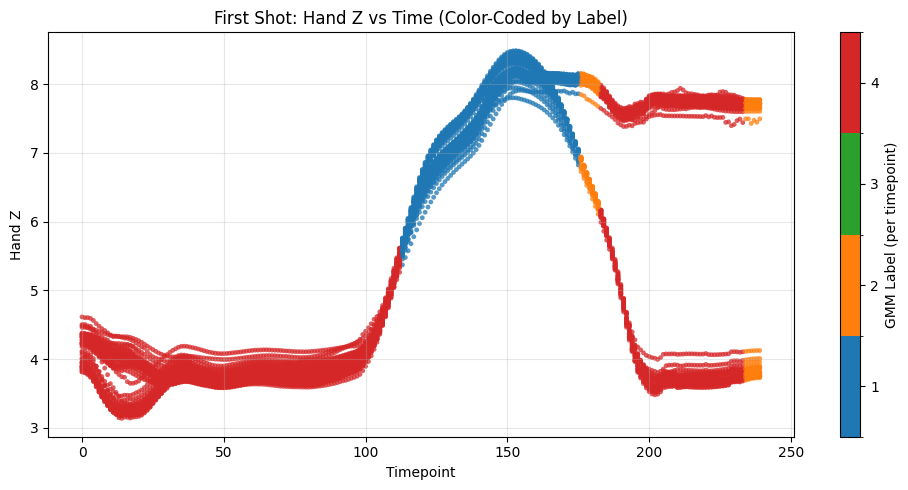

In [26]:
# Plot hand z-position over time for the first shot with GMM label color-coding
from matplotlib.colors import ListedColormap, BoundaryNorm

first_shot = shots[0]
first_labels = np.asarray(labels[0])
col_to_idx = {name: i for i, name in enumerate(signal_cols)}

# Use hand-related z columns (labels are per-timepoint from hand-based segmentation)
hand_z_cols = [c for c in hand_names if c.lower().endswith('_z')]
if not hand_z_cols:
    raise ValueError("No hand z columns found in hand_names.")

time = np.arange(first_shot.shape[1])

# Fixed 4-state discrete color mapping
state_values = [1, 2, 3, 4]
state_to_idx = {state: idx for idx, state in enumerate(state_values)}
color_values = np.array([state_to_idx.get(int(label), np.nan) for label in first_labels], dtype=float)
cmap = ListedColormap(plt.cm.tab10(np.arange(4)))
norm = BoundaryNorm(np.arange(-0.5, 4.5, 1), cmap.N)

fig, ax = plt.subplots(figsize=(10, 5))

for z_col in hand_z_cols:
    z_t = first_shot[col_to_idx[z_col], :]
    ax.scatter(time, z_t, c=color_values, cmap=cmap, norm=norm, s=12, alpha=0.75, edgecolors='none')

# Discrete 4-color colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, ticks=np.arange(4))
cbar.ax.set_yticklabels([str(state) for state in state_values])
cbar.set_label('GMM Label (per timepoint)')

ax.set_xlabel('Timepoint')
ax.set_ylabel('Hand Z')
ax.set_title('First Shot: Hand Z vs Time (Color-Coded by Label)')
ax.grid(alpha=0.3)
fig.tight_layout()
plt.show()

In [ ]:
# 

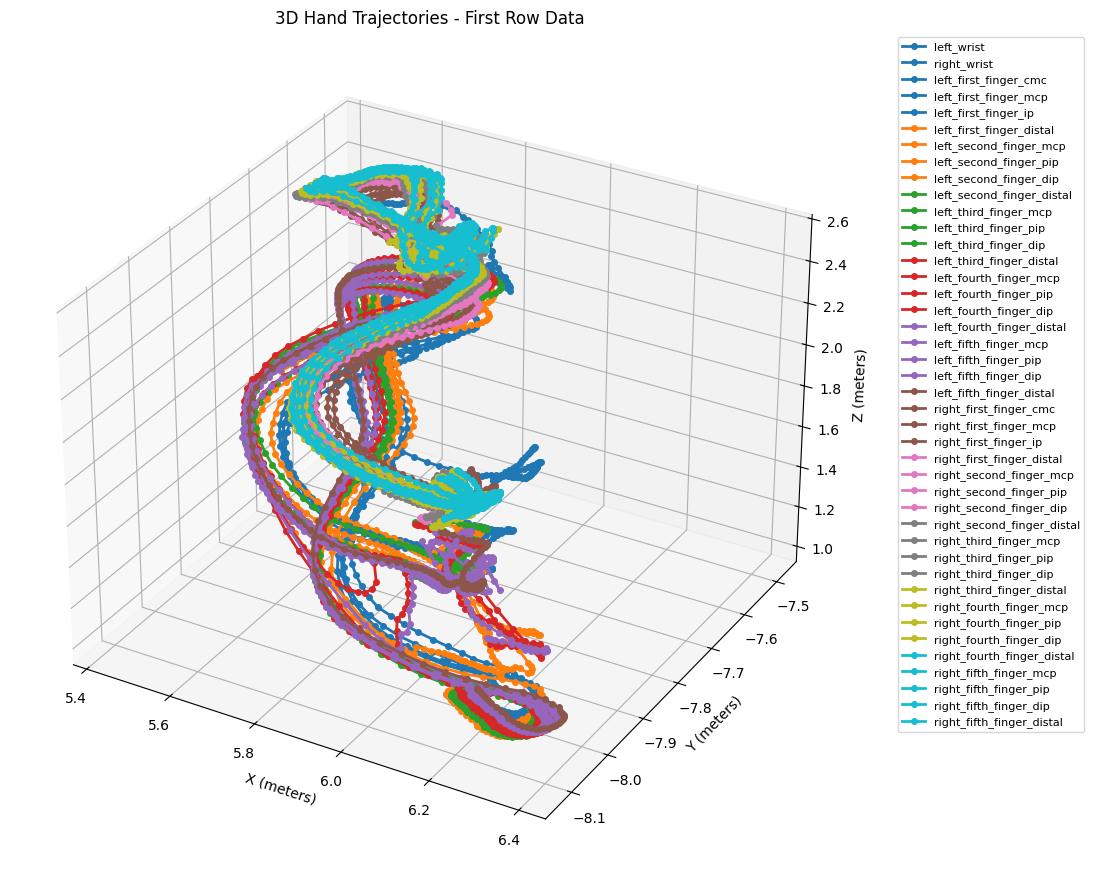

In [25]:
# Create a 3D plot for all trajectories of hand-related points from the first row
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Get the first row of data
first_row = train_data.iloc[0]

# Group hand_names by point (extract base name without x/y/z suffix)
point_names = {}
for col in hand_names:
    # Remove _x, _y, _z suffix to get the point name
    base_name = col.rsplit('_', 1)[0] if col[-2] == '_' else col
    if base_name not in point_names:
        point_names[base_name] = []
    point_names[base_name].append(col)

# Plot trajectory for each hand point
colors = plt.cm.tab10(np.linspace(0, 1, len(point_names)))

for idx, (point_name, cols) in enumerate(point_names.items()):
    # Get the x, y, z columns for this point
    x_col = [c for c in cols if c.endswith('_x')]
    y_col = [c for c in cols if c.endswith('_y')]
    z_col = [c for c in cols if c.endswith('_z')]
    
    if x_col and y_col and z_col:
        # Extract the coordinate arrays
        x = first_row[x_col[0]]
        y = first_row[y_col[0]]
        z = first_row[z_col[0]]
        
        # Create trajectory array
        trajectory_3d = np.column_stack([x, y, z])
        
        # Plot the trajectory
        ax.plot(trajectory_3d[:, 0], trajectory_3d[:, 1], trajectory_3d[:, 2], 
                marker='o', label=point_name, color=colors[idx], linewidth=2, markersize=4)

ax.set_xlabel('X (meters)')
ax.set_ylabel('Y (meters)')
ax.set_zlabel('Z (meters)')
ax.set_title('3D Hand Trajectories - First Row Data')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

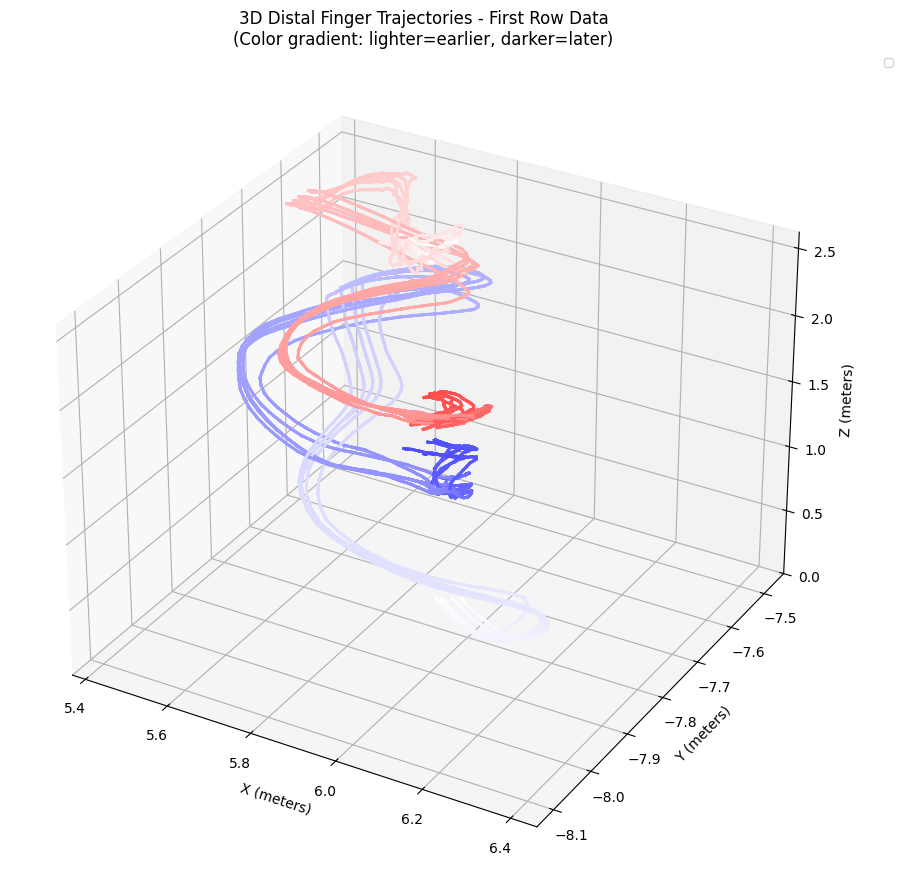

In [26]:
# Create a 3D plot for distal ends of fingers for each hand with color gradient over time
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors

# Filter for distal finger columns
distal_finger_names = [col for col in hand_names if 'distal' in col.lower() and 'finger' in col.lower()]

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Get the first row of data
first_row = train_data.iloc[0]

# Separate by hand (left vs right)
left_fingers = [col for col in distal_finger_names if 'left' in col.lower()]
right_fingers = [col for col in distal_finger_names if 'right' in col.lower()]

# Plot left hand distal fingers with gradient
for col_group in left_fingers:
    # Get the base name without x/y/z
    base_name = col_group.rsplit('_', 1)[0] if col_group[-2] == '_' else col_group
    
    x_col = [c for c in distal_finger_names if c == base_name + '_x']
    y_col = [c for c in distal_finger_names if c == base_name + '_y']
    z_col = [c for c in distal_finger_names if c == base_name + '_z']
    
    if x_col and y_col and z_col:
        x = first_row[x_col[0]]
        y = first_row[y_col[0]]
        z = first_row[z_col[0]]
        
        trajectory_3d = np.column_stack([x, y, z])
        n_points = len(trajectory_3d)
        
        # Plot each segment with gradient color from light blue to darker blue
        for i in range(n_points - 1):
            # Normalize time: 0 at start (light), 1 at end (dark)
            alpha = i / (n_points - 1)
            # Create color from light blue to darker blue
            color = (0.3 + 0.7 * alpha, 0.3 + 0.7 * alpha, 1.0)  # Light to dark blue
            
            ax.plot(trajectory_3d[i:i+2, 0], trajectory_3d[i:i+2, 1], trajectory_3d[i:i+2, 2], 
                    color=color, linewidth=2)

# Plot right hand distal fingers with gradient
for col_group in right_fingers:
    base_name = col_group.rsplit('_', 1)[0] if col_group[-2] == '_' else col_group
    
    x_col = [c for c in distal_finger_names if c == base_name + '_x']
    y_col = [c for c in distal_finger_names if c == base_name + '_y']
    z_col = [c for c in distal_finger_names if c == base_name + '_z']
    
    if x_col and y_col and z_col:
        x = first_row[x_col[0]]
        y = first_row[y_col[0]]
        z = first_row[z_col[0]]
        
        trajectory_3d = np.column_stack([x, y, z])
        n_points = len(trajectory_3d)
        
        # Plot each segment with gradient color from light red to darker red
        for i in range(n_points - 1):
            # Normalize time: 0 at start (light), 1 at end (dark)
            alpha = i / (n_points - 1)
            # Create color from light red to darker red
            color = (1.0, 0.3 + 0.7 * alpha, 0.3 + 0.7 * alpha)  # Light to dark red
            
            ax.plot(trajectory_3d[i:i+2, 0], trajectory_3d[i:i+2, 1], trajectory_3d[i:i+2, 2], 
                    color=color, linewidth=2)

ax.set_xlabel('X (meters)')
ax.set_ylabel('Y (meters)')
ax.set_zlabel('Z (meters)')
ax.set_zlim(bottom=0)
ax.set_title('3D Distal Finger Trajectories - First Row Data\n(Color gradient: lighter=earlier, darker=later)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

In [27]:
# Use estimate_ball_motion on hand data to calculate kinematic features
from physics.extract_features import estimate_ball_motion

# Get the first row of training data
first_row_idx = 0
first_row = train_data.iloc[first_row_idx]

# Separate left and right hand columns (preserve order — every 3 columns = one point)
left_hand_cols = [col for col in hand_names if 'left' in col.lower()]
right_hand_cols = [col for col in hand_names if 'right' in col.lower()]

def build_points_from_triplets(cols, row):
    """Build an array of shape (T, P, 3) from ordered columns where
    every consecutive triplet (x,y,z) forms one point.
    """
    if not cols:
        return None
    if len(cols) % 3 != 0:
        raise ValueError("Expected groups of 3 columns per point (x,y,z) for each hand)")
    pts_list = []
    for i in range(0, len(cols), 3):
        x = row[cols[i]]
        y = row[cols[i + 1]]
        z = row[cols[i + 2]]
        # Each x,y,z is an array of length T (timesteps)
        pts_list.append(np.column_stack([x, y, z]))  # (T, 3)
    # Stack into (T, P, 3)
    return np.stack(pts_list, axis=1)

# Build left/right point arrays
left_points = build_points_from_triplets(left_hand_cols, first_row)
right_points = build_points_from_triplets(right_hand_cols, first_row)

# Call estimate_ball_motion (uses timestamps spacing of 1 frame if none provided)
v_linear, omega_angular, position = estimate_ball_motion(left_points=left_points, right_points=right_points)

# Calculate linear velocity magnitude
v_magnitude = np.linalg.norm(v_linear)

# Print results
print("Hand Motion Kinematics (First Row):")
print("=" * 50)
print(f"Position (average): {position}")
print(f"Linear Velocity Vector: {v_linear}")
print(f"Linear Velocity Magnitude: {v_magnitude:.4f} (units/frame)")
print(f"Angular Velocity: {omega_angular}")
print("=" * 50)

# Mark todo done



ImportError: cannot import name 'X_COURT' from 'physics.constants' (c:\Users\caitken5.stu\Documents\GitHub\CMSZ-SPLxUTSPAN-2026-Data-Challenge\physics\constants.py)

## 4. Prepare Initial Trajectory Data

In [ ]:
# Extract trajectory features from last 0.1 seconds of data prior to ball release.


In [ ]:
# Feature Generation

## 5. Build Neural Network Component

## 7. Evaluate Model Performance